# Import

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
import os
import sys
import datetime

# Ensure we can import from local modules
sys.path.append(os.getcwd())

# Define Paths
MODEL_DIR = './models'
ANOMALY_PATH = os.path.join(MODEL_DIR, 'anomaly_model.pkl')
FORECAST_PATH = os.path.join(MODEL_DIR, 'forecast_model.pkl')
LSTM_PATH = os.path.join(MODEL_DIR, 'lstm_forecast_model.pth')

print("✅ Libraries loaded. Paths defined.")

✅ Libraries loaded. Paths defined.


# Load models

In [20]:
# 1. Load Anomaly & RF Models
try:
    anomaly_data = joblib.load(ANOMALY_PATH)
    
    # Handle different save formats
    if isinstance(anomaly_data, dict):
        anomaly_model = anomaly_data['model']
        # Dynamically get features the model expects
        if 'features' in anomaly_data:
            anomaly_features = anomaly_data['features']
        elif hasattr(anomaly_model, 'feature_names_in_'):
            anomaly_features = list(anomaly_model.feature_names_in_)
        else:
            # Fallback for very old models
            anomaly_features = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
    else:
        anomaly_model = anomaly_data
        anomaly_features = ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']

    print(f"✅ Anomaly Model loaded.")
    print(f"   Expecting features: {anomaly_features}")
    
    try:
        rf_model = joblib.load(FORECAST_PATH)
        print(f"✅ Random Forest Model loaded.")
    except:
        print("⚠️ Random Forest model not found (Skipping).")
        rf_model = None

except FileNotFoundError:
    print("❌ Scikit-learn models not found. Run 'python ai_engine/trainer.py' first.")
    anomaly_features = []

# 2. Define LSTM Class (3 Inputs: Value, Is_WLAN, Is_Ping)
class LSTMUniversal(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMUniversal, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 3. Load LSTM Weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = None

if os.path.exists(LSTM_PATH):
    try:
        lstm_model = LSTMUniversal(input_size=3, output_size=1).to(device)
        lstm_model.load_state_dict(torch.load(LSTM_PATH, map_location=device))
        lstm_model.eval()
        print(f"✅ LSTM model loaded on {device}.")
    except Exception as e:
        print(f"❌ Error loading LSTM: {e}")
else:
    print("⚠️ LSTM model file not found.")

✅ Anomaly Model loaded.
   Expecting features: ['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']
✅ Random Forest Model loaded.
✅ LSTM model loaded on cpu.


In [35]:
from trainer import fetch_real_data
df, baselines = fetch_real_data()
df.head()

🔌 Connecting to Prometheus at http://158.108.4.150:9090...
📥 Fetching last 14 days of metrics...
   ...Processing and merging data frames...
✅ Fetched 12761 real data points.


,timestamp,hostname,lan_down,lan_up,wlan_down,wlan_up,lan_ping,hour,day_of_week,is_weekend,wlan_ping,lan_dns,wlan_dns
0,2026-01-14 08:45:41,50Y-F4,0.960602,0.603941,0.555734,0.418222,0.973778,8,2,0,0,0,0
1,2026-01-14 08:45:41,50Y-F5,0.998891,0.977414,0.003948,0.004060,0.888826,8,2,0,0,0,0
2,2026-01-14 08:45:41,AGR-AGR5,0.000000,0.000000,0.000000,0.000000,0.000000,8,2,0,0,0,0
3,2026-01-14 08:45:41,ARCH-B1,1.001293,0.991202,0.826219,0.809180,0.915309,8,2,0,0,0,0
4,2026-01-14 08:45:41,BUS-B1,0.995237,0.668903,0.417454,0.094895,0.957536,8,2,0,0,0,0


# Generate Test Data

In [32]:
# Cell 3: Generate Test Data (Capacity Mode)
def generate_test_data(hours=168): # 1 week
    print("🧪 Generating CAPACITY data...")
    start = datetime.datetime.now() - datetime.timedelta(hours=hours)
    dates = [start + datetime.timedelta(hours=i) for i in range(hours)]
    df = pd.DataFrame({'timestamp': dates})
    
    # Time Features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    lan_downs = []
    wlan_downs = []
    
    for i, row in df.iterrows():
        h = row['hour']
        w = row['is_weekend']
        
        # Congestion Pattern:
        # Weekday: High congestion (lower speed) at 14:00
        if w == 0: congestion = 0.05 * np.exp(-((h - 14)**2) / 15) 
        else: congestion = 0.3 * np.exp(-((h - 20)**2) / 20) 
        
        # Speed = 1000 Mbps * (1.0 - Congestion)
        # Stable LAN: very little noise
        val_pct = max(0.1, 1.0 - congestion + np.random.normal(0, 0.01))
        
        lan_downs.append(val_pct * 1000)

    for i, row in df.iterrows():
        h = row['hour']
        w = row['is_weekend']
        
        if w == 0: congestion = 0.05 * np.exp(-((h - 14)**2) / 15) 
        else: congestion = 0.3 * np.exp(-((h - 20)**2) / 20) 
        
        val_pct = max(0.4, 1.0 - congestion + np.random.normal(0, 0.05))
        
        wlan_downs.append(val_pct * 1000)


    df['lan_down'] = lan_downs
    df['lan_up'] = df['lan_down'] * 0.9
    df['wlan_down'] = wlan_downs # WLAN slower/more congested
    df['wlan_up'] = df['wlan_down'] * 0.5
    
    # Latency rises with congestion
    # Base 2ms + up to 10ms jitter
    congestion_factor = (1000 - df['lan_down']) / 1000
    df['lan_ping'] = 2.0 + (congestion_factor * 5) + np.random.normal(0, 0.5, hours)
    df['wlan_ping'] = df['lan_ping'] * 5.0
    
    df['lan_dns'] = 0.2
    df['wlan_dns'] = 0.2
    
    return df

df = generate_test_data()
print(f"✅ Generated {len(df)} hours of capacity data.")
df.head()

🧪 Generating CAPACITY data...
✅ Generated 168 hours of capacity data.


,timestamp,hour,day_of_week,is_weekend,lan_down,lan_up,wlan_down,wlan_up,lan_ping,wlan_ping,lan_dns,wlan_dns
0,2026-01-21 14:35:43.648191,14,2,0,945.729861,851.156875,990.417208,495.208604,1.517873,7.589367,0.2,0.2
1,2026-01-21 15:35:43.648191,15,2,0,939.006362,845.105726,847.148274,423.574137,2.807941,14.039706,0.2,0.2
2,2026-01-21 16:35:43.648191,16,2,0,969.414495,872.473046,1003.268020,501.634010,2.353880,11.769399,0.2,0.2
3,2026-01-21 17:35:43.648191,17,2,0,969.547784,872.593005,894.695542,447.347771,2.608792,13.043962,0.2,0.2
4,2026-01-21 18:35:43.648191,18,2,0,983.104482,884.794033,1032.318268,516.159134,1.879069,9.395345,0.2,0.2


# Anomaly detection test

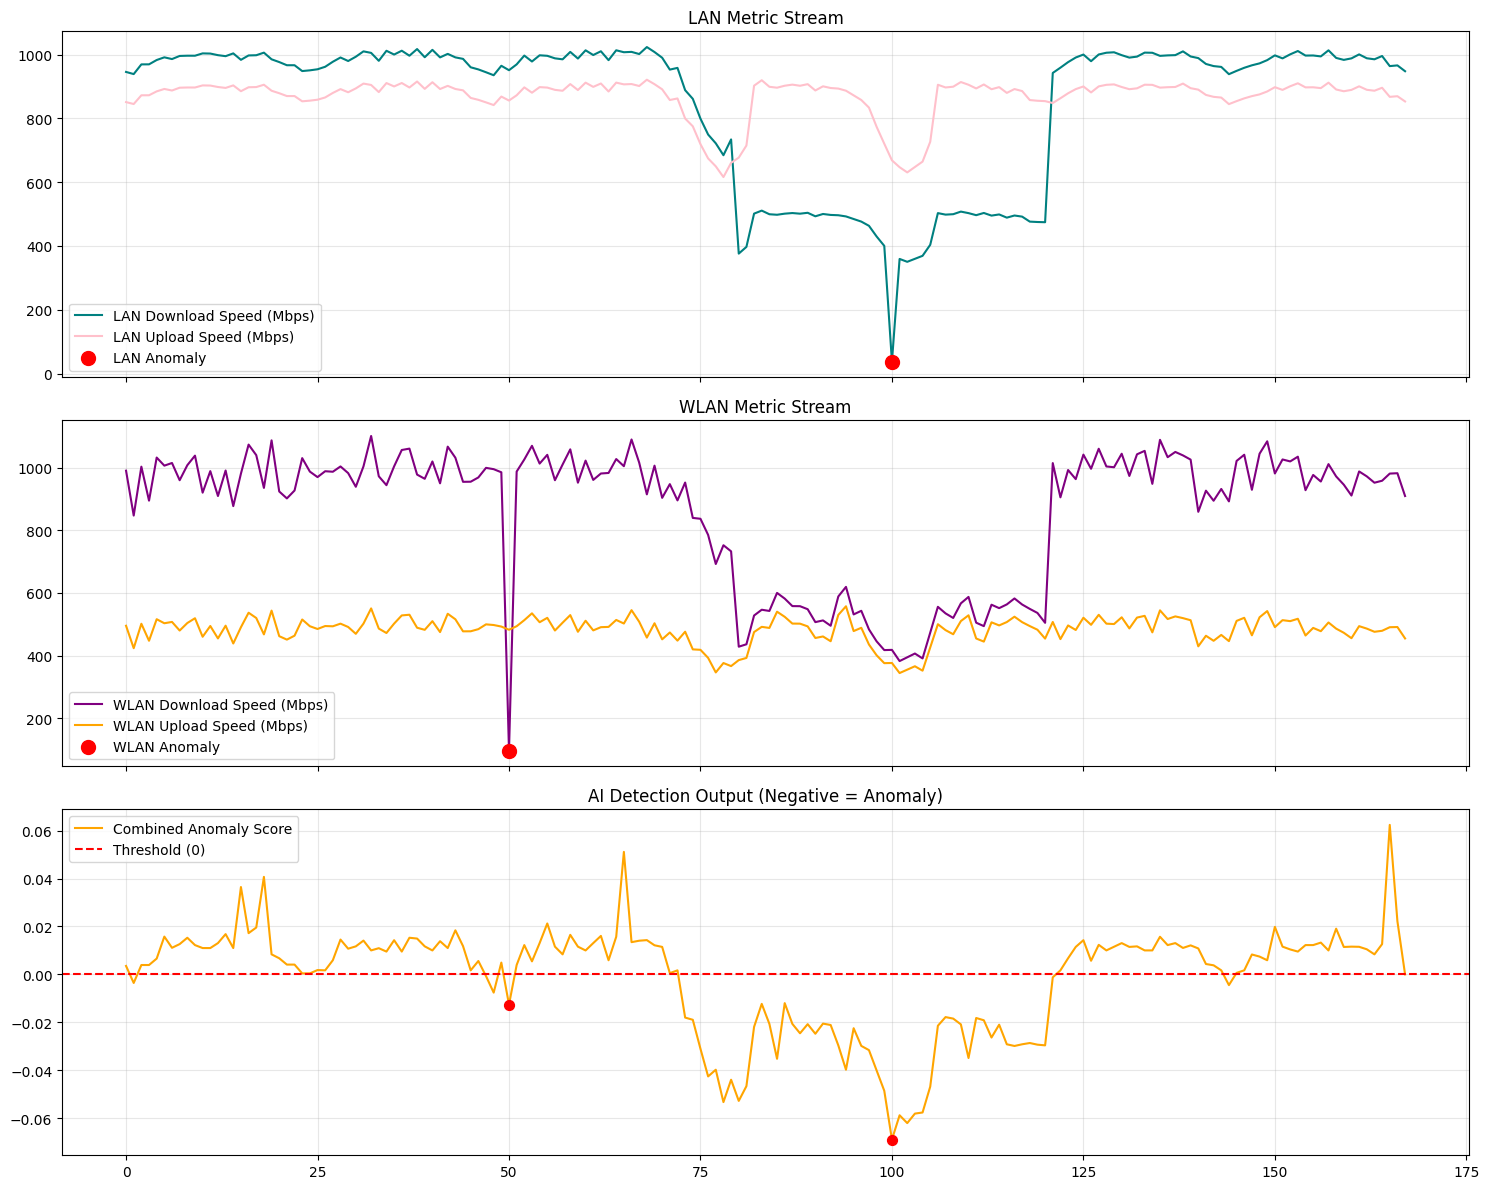

WLAN Anomaly Score (Index 50): -0.0126
LAN Anomaly Score  (Index 100): -0.0688


In [33]:
# 1. Create a dataset with anomalies
df_anom = df.copy()

# Scenario A: WLAN Anomaly at Index 50 (e.g., Interference)
# Normal WLAN is ~300-500 Mbps. Drop to 10.
# Normal WLAN Ping is ~20ms. Spike to 300ms.
idx_wlan = 50
df_anom.loc[idx_wlan, 'wlan_down'] /= 10 
df_anom.loc[idx_wlan, 'wlan_ping'] *= 10

# Scenario B: LAN Anomaly at Index 100 (e.g., Cut Cable)
# Normal LAN is ~800 Mbps. Drop to 10.
idx_lan = 100
df_anom.loc[idx_lan, 'lan_down'] /= 10
df_anom.loc[idx_lan, 'lan_ping'] *= 10

idx_fluct = 80
idx_fluct_end = 120
df_anom.loc[idx_fluct:idx_fluct_end, 'lan_down'] /= 2
df_anom.loc[idx_fluct:idx_fluct_end, 'wlan_down'] /= 1.8
# 2. Normalize Data for Model
X_anom = df_anom.copy()

# Hardcoded baselines matching synthetic data generation
# (In real app, these come from 'baselines' in the loaded model file)
X_anom['lan_down'] /= 1000
X_anom['lan_up'] /= 1000
X_anom['wlan_down'] /= 600  # Approx max for WLAN in synthetic data
X_anom['wlan_up'] /= 300

# 3. Filter Columns
if 'anomaly_features' in globals() and anomaly_features:
    X_final = X_anom[anomaly_features]
else:
    X_final = X_anom[['lan_down', 'lan_up', 'wlan_down', 'wlan_up', 'lan_ping', 'wlan_ping', 'lan_dns', 'wlan_dns']]

# 4. Predict
preds = anomaly_model.predict(X_final)
scores = anomaly_model.decision_function(X_final)
df_anom['anomaly'] = preds
df_anom['score'] = scores

# 5. Plot
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot LAN Speed
axes[0].plot(df_anom.index, df_anom['lan_down'], label='LAN Download Speed (Mbps)', color='teal')
axes[0].plot(df_anom.index, df_anom['lan_up'], label='LAN Upload Speed (Mbps)', color='pink')
axes[0].scatter(idx_lan, df_anom.loc[idx_lan, 'lan_down'], color='red', s=100, label='LAN Anomaly', zorder=5)
axes[0].set_title("LAN Metric Stream")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot WLAN Speed
axes[1].plot(df_anom.index, df_anom['wlan_down'], label='WLAN Download Speed (Mbps)', color='purple')
axes[1].plot(df_anom.index, df_anom['wlan_up'], label='WLAN Upload Speed (Mbps)', color='orange')
axes[1].scatter(idx_wlan, df_anom.loc[idx_wlan, 'wlan_down'], color='red', s=100, label='WLAN Anomaly', zorder=5)
axes[1].set_title("WLAN Metric Stream")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot Anomaly Score
axes[2].plot(df_anom.index, df_anom['score'], label='Combined Anomaly Score', color='orange')
axes[2].axhline(y=0, color='red', linestyle='--', label='Threshold (0)')
axes[2].scatter([idx_wlan, idx_lan], [df_anom.loc[idx_wlan, 'score'], df_anom.loc[idx_lan, 'score']], color='red', s=50, zorder=5)
axes[2].set_title("AI Detection Output (Negative = Anomaly)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"WLAN Anomaly Score (Index {idx_wlan}): {df_anom.loc[idx_wlan, 'score']:.4f}")
print(f"LAN Anomaly Score  (Index {idx_lan}): {df_anom.loc[idx_lan, 'score']:.4f}")

🌲 Generating Random Forest Prediction...
   RF Predictions generated. Mean: 890.79

🧠 Generating LSTM Prediction...
   LSTM Predictions generated. Count: 144

📈 Plotting results...


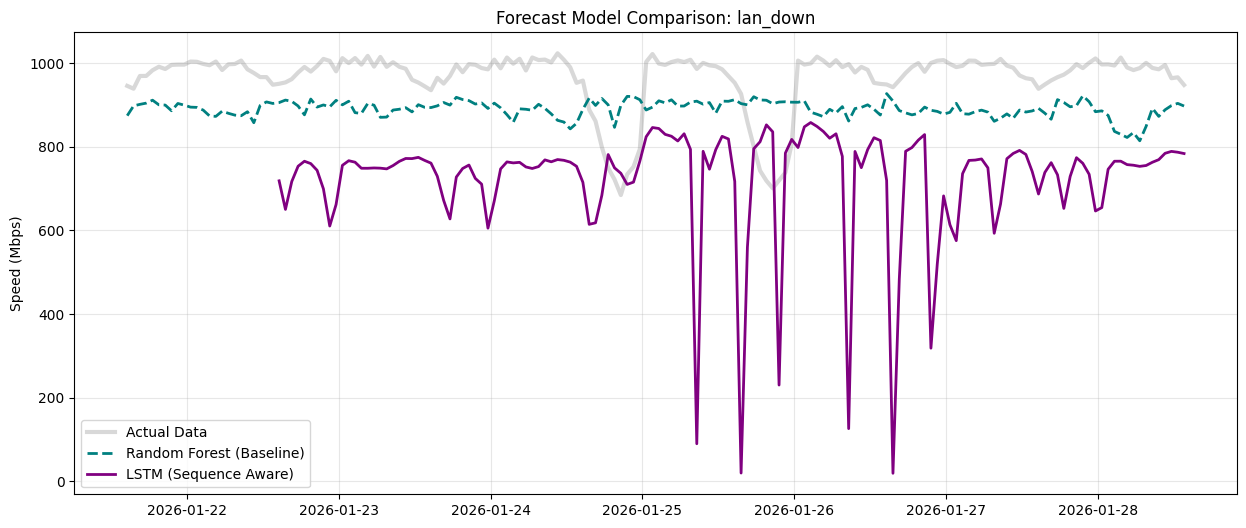

In [34]:
# Cell 5: Visualize Forecasting (Robust Version)

# Configuration
target_col = 'lan_down'
is_wlan = 0.0
is_ping = 0.0
max_val = 1000.0 

# 1. Random Forest Prediction
print("🌲 Generating Random Forest Prediction...")
X_rf = df[['hour', 'day_of_week', 'is_weekend']]
try:
    if 'rf_model' in globals() and rf_model:
        rf_preds_raw = rf_model.predict(X_rf) 
        # Handle Multi-Output (Speed, Ping) vs Single Output
        if rf_preds_raw.ndim > 1 and rf_preds_raw.shape[1] > 1:
            df['rf_pred'] = rf_preds_raw[:, 0] * max_val
        else:
            df['rf_pred'] = rf_preds_raw * max_val
        print(f"   RF Predictions generated. Mean: {df['rf_pred'].mean():.2f}")
    else:
        print("   ⚠️ RF Model not loaded. Skipping RF plot.")
        df['rf_pred'] = np.nan
except Exception as e:
    print(f"   ⚠️ RF Prediction failed: {e}")
    df['rf_pred'] = np.nan

# 2. LSTM Prediction
print("\n🧠 Generating LSTM Prediction...")
seq_length = 24 
lstm_preds = [np.nan] * seq_length # Pad start with NaNs

# Prepare Input Data [Value, Is_WLAN, Is_Ping]
vals_norm = df[target_col].values / max_val
wlan_flags = np.full(len(df), is_wlan)
ping_flags = np.full(len(df), is_ping)
data_matrix = np.column_stack((vals_norm, wlan_flags, ping_flags)).astype(np.float32)

if 'lstm_model' in globals() and lstm_model:
    lstm_model.eval() # Ensure eval mode
    preds_list = []
    try:
        with torch.no_grad():
            for i in range(len(df) - seq_length):
                # Create sequence [1, seq_len, 3]
                seq = data_matrix[i : i+seq_length]
                input_tensor = torch.from_numpy(seq).view(1, seq_length, 3).to(device)
                
                # Predict
                pred = lstm_model(input_tensor)
                val = pred.item()
                preds_list.append(val * max_val)
        
        # Extend dataframe
        lstm_preds.extend(preds_list)
        df['lstm_pred'] = lstm_preds
        print(f"   LSTM Predictions generated. Count: {len(preds_list)}")
    except Exception as e:
        print(f"   ⚠️ LSTM Prediction failed: {e}")
        df['lstm_pred'] = np.nan
else:
    print("   ⚠️ LSTM Model not loaded. Skipping LSTM plot.")
    df['lstm_pred'] = np.nan

# 3. Plotting
print("\n📈 Plotting results...")
plt.figure(figsize=(15, 6))

# Plot Actual
plt.plot(df['timestamp'], df[target_col], label='Actual Data', color='gray', alpha=0.3, linewidth=3)

# Plot RF (if available)
if not df['rf_pred'].isnull().all():
    plt.plot(df['timestamp'], df['rf_pred'], label='Random Forest (Baseline)', color='teal', linestyle='--', linewidth=2)

# Plot LSTM (if available)
if not df['lstm_pred'].isnull().all():
    plt.plot(df['timestamp'], df['lstm_pred'], label='LSTM (Sequence Aware)', color='purple', linewidth=2)

plt.title(f"Forecast Model Comparison: {target_col}")
plt.ylabel("Speed (Mbps)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()